**Op-Ed Article: Covid's Next Problem** <br>
*Jake Schneider & Peter McKelvey* <br>
May 2020

----

**Load Libraries**

In [1]:
#Import libraries
import sys
import pandas as pd
from datetime import date, datetime, time, timedelta
import pendulum
import json
import requests
import numpy as np
import math

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='ticks', context='talk')

from matplotlib.offsetbox import AnchoredText
from sklearn import linear_model
from sklearn.metrics import r2_score
import statsmodels.api as sm
#import fbprophet

import statistics 
from statistics import mode 

from collections import OrderedDict 

import warnings
import itertools

from matplotlib.backends.backend_pdf import PdfPages
from fpdf import FPDF
from PIL import Image

----

**Load Data**

In [2]:
# Load Data from SHED Survey
# Data available from: https://www.federalreserve.gov/consumerscommunities/shed_data.htm

shed_df = pd.read_csv('../2_Inputs/SHED Data/publicApril2020_revised.csv')

In [3]:
# View SHED Data

shed_df.head()

,CASEID,weight,B2,EF3_a,EF3_b,EF3_c,EF3_d,EF3_e,EF3_f,EF3_g,...,pprent,ppwork,ppnet,ppt01,ppt1317,ppt18ov,ppt25,ppt612,SSTNO,ind1
0,1,0.551009,Doing okay,No,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - retired,9,0,0,3,0,0,70,-2
1,2,0.831331,Doing okay,Yes,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - as a paid employee,9,0,1,2,0,1,70,"Utilities, Waste Management, and Remediation S..."
2,3,1.435291,Doing okay,No,Yes,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - retired,9,0,0,1,0,0,70,-2
3,4,0.602249,Living comfortably,Yes,No,No,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - self-employed,9,0,0,2,0,0,70,Community/Non-Profit Organizations (including ...
4,5,0.826866,Just getting by,No,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - self-employed,9,0,0,4,0,0,70,Manufacturing


In [4]:
# View working variable 'ppwork'

shed_df['ppwork'].head()

0           Not working - retired
1    Working - as a paid employee
2           Not working - retired
3         Working - self-employed
4         Working - self-employed
Name: ppwork, dtype: object

----

In [5]:
# Create variables for working from 'ppwork'

working = shed_df.loc[(shed_df['ppwork'] == 'Working - as a paid employee') | (shed_df['ppwork'] == 'Working - self-employed')]
working.head()

,CASEID,weight,B2,EF3_a,EF3_b,EF3_c,EF3_d,EF3_e,EF3_f,EF3_g,...,pprent,ppwork,ppnet,ppt01,ppt1317,ppt18ov,ppt25,ppt612,SSTNO,ind1
1,2,0.831331,Doing okay,Yes,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - as a paid employee,9,0,1,2,0,1,70,"Utilities, Waste Management, and Remediation S..."
3,4,0.602249,Living comfortably,Yes,No,No,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - self-employed,9,0,0,2,0,0,70,Community/Non-Profit Organizations (including ...
4,5,0.826866,Just getting by,No,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - self-employed,9,0,0,4,0,0,70,Manufacturing
5,6,0.957646,Living comfortably,Yes,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - as a paid employee,9,0,0,5,0,0,70,Repairs and Maintenance
7,8,1.311333,Doing okay,Yes,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Working - as a paid employee,9,0,0,3,0,0,70,Health Care and Social Assistance


In [6]:
# Create variables for laid_off from 'ppwork'

laid_off = shed_df.loc[(shed_df['ppwork'] == 'Not working - on temporary layoff from a job') | (shed_df['ppwork'] == 'Not working - looking for work')]
laid_off.head()

,CASEID,weight,B2,EF3_a,EF3_b,EF3_c,EF3_d,EF3_e,EF3_f,EF3_g,...,pprent,ppwork,ppnet,ppt01,ppt1317,ppt18ov,ppt25,ppt612,SSTNO,ind1
8,9,1.025913,Doing okay,No,No,Yes,No,No,No,No,...,Rented for cash,Not working - looking for work,9,0,0,1,0,0,70,-2
151,152,1.024331,Doing okay,No,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - looking for work,9,0,1,6,0,0,70,-2
191,192,0.816090,Just getting by,No,Yes,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - looking for work,9,0,0,2,0,0,70,-2
214,215,1.018425,Living comfortably,Refused,Refused,Refused,Refused,Refused,Refused,Refused,...,Owned or being bought by you or someone in you...,Not working - looking for work,9,0,0,1,0,0,70,-2
241,242,2.267510,Doing okay,No,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - looking for work,9,0,0,12,0,0,70,-2


In [7]:
# Create variable for laid_off_with_other from 'ppwork'

laid_off_with_other = shed_df.loc[(shed_df['ppwork'] == 'Not working - on temporary layoff from a job') | (shed_df['ppwork'] == 'Not working - looking for work') | (shed_df['ppwork'] == 'Not working - other')]
laid_off_with_other.head()

,CASEID,weight,B2,EF3_a,EF3_b,EF3_c,EF3_d,EF3_e,EF3_f,EF3_g,...,pprent,ppwork,ppnet,ppt01,ppt1317,ppt18ov,ppt25,ppt612,SSTNO,ind1
8,9,1.025913,Doing okay,No,No,Yes,No,No,No,No,...,Rented for cash,Not working - looking for work,9,0,0,1,0,0,70,-2
36,37,0.844489,Doing okay,No,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - other,9,0,0,3,0,0,70,-2
85,86,0.452383,Doing okay,No,Yes,No,No,No,No,No,...,Rented for cash,Not working - other,9,0,0,4,0,0,70,-2
91,92,0.771401,Doing okay,Yes,No,No,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - other,9,0,2,2,0,1,70,-2
113,114,0.931940,Living comfortably,No,No,Yes,No,No,No,No,...,Owned or being bought by you or someone in you...,Not working - other,9,0,2,2,1,3,70,-2


In [8]:
# Confirm group totals are correct

print('Total Working', working['CASEID'].count())
print('Total Laid Off:', laid_off['CASEID'].count())
print('Total Laid Off (With Other):', laid_off_with_other['CASEID'].count())

Total Working 632
Total Laid Off: 46
Total Laid Off (With Other): 113


In [9]:
# Create function for most common observation

def most_common(List): 
    return(mode(List)) 

In [10]:
# Print average income of groups

print('Most Frequent Working Group Income:', most_common(working['ppincimp']))
print('Most Frequent Laid Off Group Income:', most_common(laid_off['ppincimp']))
print('Most Frequent Laif Off With Other Group Income:', most_common(laid_off_with_other['ppincimp']))

Most Frequent Working Group Income: $100,000 to $124,999
Most Frequent Laid Off Group Income: $50,000 to $59,999
Most Frequent Laif Off With Other Group Income: $50,000 to $59,999


In [11]:
# Create a function to count the number of items

#def count_elements(seq) -> dict:
#    """Tally elements from `seq`."""
#    hist = {}
#    for i in seq:
#        hist[i] = hist.get(i, 0) + 1
#    return hist

def count_elements(seq, seq1) -> dict:
    "Count weighted values from `seq`"
    hist = {}
    for item, item1 in zip(seq, seq1):
        if not item in hist:
            hist[item]=item1
        else:
            hist[item]+=item1
    
    return hist

In [12]:
# Count Working

working_counts = count_elements(working['ppincimp'], working['weight'])
working_counts

{'$40,000 to $49,999': 32.9271015,
 '$100,000 to $124,999': 80.22265609999994,
 '$200,000 to $249,999': 26.1066532,
 '$75,000 to $84,999': 42.58133000000001,
 '$60,000 to $74,999': 54.7489806,
 '$250,000 or more': 31.2555387,
 '$125,000 to $149,999': 47.69379280000002,
 '$175,000 to $199,999': 36.87807560000001,
 '$25,000 to $29,999': 19.795320900000004,
 '$30,000 to $34,999': 21.9545746,
 '$150,000 to $174,999': 55.574102100000005,
 '$85,000 to $99,999': 46.191300999999996,
 '$50,000 to $59,999': 45.3017238,
 '$35,000 to $39,999': 17.8975376,
 '$20,000 to $24,999': 17.6911668,
 '$12,500 to $14,999': 3.2711938000000003,
 '$15,000 to $19,999': 9.2349505,
 'Less than $5,000': 6.584424199999999,
 '$5,000 to $7,499': 3.5111537000000004,
 '$7,500 to $9,999': 2.3049736999999997,
 '$10,000 to $12,499': 4.4097382000000005}

In [13]:
# Count Laid_Off

laid_off_counts = count_elements(laid_off['ppincimp'], laid_off['weight'])
laid_off_counts

{'$25,000 to $29,999': 1.0259126,
 '$60,000 to $74,999': 4.1094178,
 '$20,000 to $24,999': 2.8058520000000002,
 '$250,000 or more': 2.1659276,
 '$35,000 to $39,999': 5.0024999,
 '$15,000 to $19,999': 3.1636189000000003,
 '$75,000 to $84,999': 4.4284999,
 '$85,000 to $99,999': 4.0200764,
 '$100,000 to $124,999': 2.2219103000000002,
 '$40,000 to $49,999': 3.4431041000000002,
 '$125,000 to $149,999': 1.3871163,
 'Less than $5,000': 6.8166207,
 '$200,000 to $249,999': 0.7945698,
 '$7,500 to $9,999': 3.5721562000000002,
 '$10,000 to $12,499': 1.4617949,
 '$30,000 to $34,999': 2.230603,
 '$50,000 to $59,999': 8.4473772,
 '$5,000 to $7,499': 1.3979993999999998,
 '$175,000 to $199,999': 1.4846826000000002,
 '$150,000 to $174,999': 0.9869485}

In [14]:
counts_df = pd.DataFrame({
    'working_counts': working_counts,
    'laid_off_counts': laid_off_counts,
    'legend': [11,15,19,13,12,20,16,18,8,9,17,14,11.5,10,7,5,6,1,2,3,4]
    }, index=working_counts.keys())
counts_df = counts_df.sort_values(by = ['legend'])
counts_df

,working_counts,laid_off_counts,legend
"Less than $5,000",6.584424,6.816621,1.0
"$5,000 to $7,499",3.511154,1.397999,2.0
"$7,500 to $9,999",2.304974,3.572156,3.0
"$10,000 to $12,499",4.409738,1.461795,4.0
"$12,500 to $14,999",3.271194,NaN,5.0
"$15,000 to $19,999",9.234951,3.163619,6.0
"$20,000 to $24,999",17.691167,2.805852,7.0
"$25,000 to $29,999",19.795321,1.025913,8.0
"$30,000 to $34,999",21.954575,2.230603,9.0
"$35,000 to $39,999",17.897538,5.002500,10.0


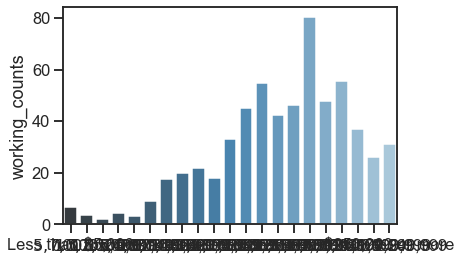

In [15]:
ax = sns.barplot(x=counts_df.index, y=counts_df['working_counts'], palette="Blues_d")
plt.show()

#fig, ax1 = plt.subplots(figsize=(10, 10))
#tidy = counts_df.melt(id_vars=counts_df.index).rename(columns=str.title)
#sns.barplot(x=counts_df.index, y='Value', hue='Less than $5,000', data=tidy, ax=ax1)
#sns.despine(fig)

#plt.bar(working_counts.keys(), working_counts.values(), width, color='g')
#plt.show()

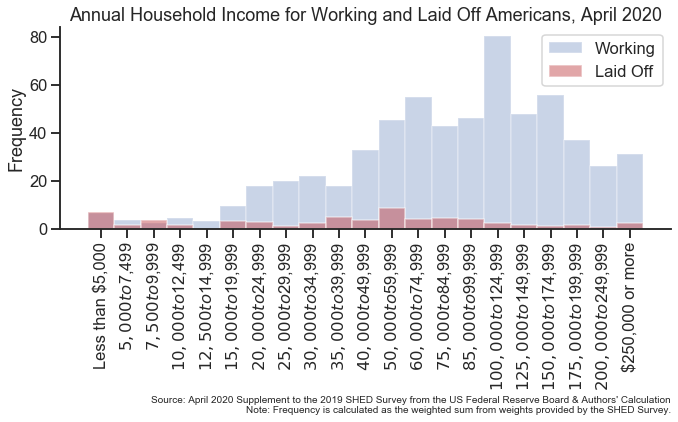

In [16]:
# data to plot
n_groups = 21
working = counts_df['working_counts']
laid_off = counts_df['laid_off_counts']

# create plot
fig, ax = plt.subplots(figsize=(10, 11.5))
index = np.arange(n_groups)
bar_width = 1.0
opacity = 0.3
opacity1 = 0.5

rects1 = plt.bar(index + bar_width, working, bar_width,
alpha=opacity,
color='b',
label='Working')

rects2 = plt.bar(index + bar_width, laid_off, bar_width,
alpha=opacity1,
color='r',
label='Laid Off')

#plt.xlabel('Income Range')
plt.ylabel('Frequency')
plt.title('Annual Household Income for Working and Laid Off Americans, April 2020')
plt.xticks(index + bar_width, counts_df.index, rotation = 90)
#plt.text(0, 0, t, style='oblique', ha = 'center', va = 'top', wrap = True)
plt.legend()

plt.annotate("Source: April 2020 Supplement to the 2019 SHED Survey from the US Federal Reserve Board & Authors' Calculation",
            xy=(1.0, -0.85),
            xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='center',
            size = 10)

plt.annotate("Note: Frequency is calculated as the weighted sum from weights provided by the SHED Survey.",
            xy=(1.0, -0.9),
            xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='center',
            size = 10)

plt.tight_layout()
sns.despine()
plt.savefig('../3_Outputs/Annual Household Income Chart April 2020.jpg', dpi=300, bbox_inches='tight')
plt.show()

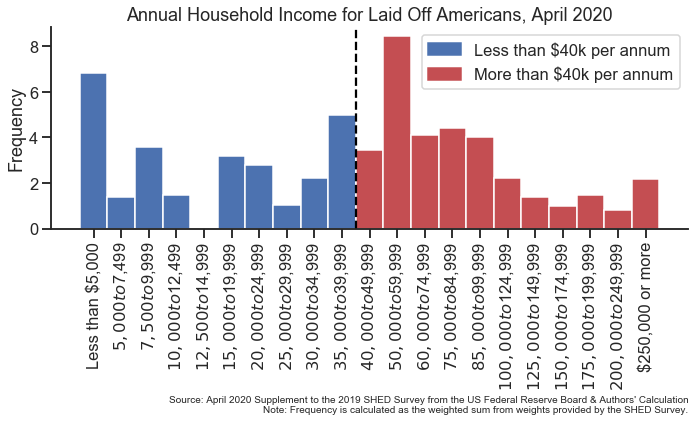

In [17]:
# data to plot
n_groups = 21
working = counts_df['working_counts']
laid_off = counts_df['laid_off_counts']
laid_off1 = counts_df.loc[counts_df['legend'] < 11.5, 'laid_off_counts']
laid_off2 = counts_df.loc[counts_df['legend'] >= 11.5, 'laid_off_counts']


# create plot
fig, ax = plt.subplots(figsize=(10, 11.5))
index = np.arange(n_groups)
bar_width = 1.0
opacity = 0.3
opacity1 = 0.5
colors = ['b','b','b','b','b','b','b','b','b','b','r','r','r','r','r','r','r','r','r','r','r']

#rects1 = plt.bar(index + bar_width, laid_off, bar_width,
#alpha=opacity,
#color='b',
#label='Working')

rects2 = plt.bar(index + bar_width, laid_off, bar_width,
#alpha=opacity1,
color=colors,
label='Laid Off')

#plt.xlabel('Income Range')
plt.ylabel('Frequency')
plt.title('Annual Household Income for Laid Off Americans, April 2020')
plt.xticks(index + bar_width, counts_df.index, rotation = 90)
plt.axvline(x=10.5, color = 'black', linestyle = '--')
#plt.text(0, 0, t, style='oblique', ha = 'center', va = 'top', wrap = True)

colors1 = {'Less than $40k per annum':'b', 'More than $40k per annum':'r'}         
labels = list(colors1.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors1[label]) for label in labels]
plt.legend(handles, labels)

plt.annotate("Source: April 2020 Supplement to the 2019 SHED Survey from the US Federal Reserve Board & Authors' Calculation",
            xy=(1.0, -0.85),
            xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='center',
            size = 10)

plt.annotate("Note: Frequency is calculated as the weighted sum from weights provided by the SHED Survey.",
            xy=(1.0, -0.9),
            xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='center',
            size = 10)

plt.tight_layout()
sns.despine()
plt.savefig('../3_Outputs/Annual Household Income Chart April 2020 (2).jpg', dpi=300, bbox_inches='tight')
plt.show()